# Model Comparison Analysis

Compare LLM social metrics across different judge models to assess inter-rater reliability.

In [75]:
# === IMPORTS ===
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from dnd_dynamics.analysis import data_loading as dl
from dnd_dynamics.analysis import metrics
from dnd_dynamics.analysis import plot_utils as pu

plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 8})

OUTPUT_DIR = Path('plots')
OUTPUT_DIR.mkdir(exist_ok=True)

In [101]:
# === CONFIGURATION ===

# Models to compare
MODELS = [
    'gemini/gemini-2.0-flash',
    'gemini/gemini-3-flash-preview',
    'claude-sonnet-4-5',
]
MODEL_LABELS = ['Gemini 2.0 Flash', 'Gemini 3 Flash', 'Claude Sonnet 4.5']

# Campaign configuration (same as game_log_analysis_tutorial)
CAMPAIGN_BASE_NAMES = [
    '1262-firedeath-must-die-closed-play-by-post-open-ogg',
    '3135-the-head-of-the-serpent',
    '10391-guardians-of-gridori',
    '20049-age-of-death',
    '89221-banhaven-academy-year-1',
    '90630-firecat5s-dragon-of-icespire-peak',
    '7426-serpent-isle-private-campaign',
]

LLM_FILTER = {
    'model': ['gpt-4o', 'gemini-1.5-pro', 'claude-3-7-sonnet-latest'],
    'campaign_name': CAMPAIGN_BASE_NAMES,
    'include_player_personalities': [True, False],
    'year': 2025,
    'scratchpad': True,
}

CATEGORY_FIELDS = ['model', 'include_player_personalities']
MESSAGES_PER_SESSION = 5
FORCE_REFRESH = False

In [85]:
# === DATA LOADING ===

dfs_human = dl.load_campaigns(CAMPAIGN_BASE_NAMES, messages_per_session=MESSAGES_PER_SESSION)
dfs_llm = dl.load_campaigns('llm', messages_per_session=MESSAGES_PER_SESSION, filter_by=LLM_FILTER)
dfs = {**dfs_human, **dfs_llm}

print(f"Loaded {len(dfs_human)} human campaigns, {len(dfs_llm)} LLM campaigns")
print(f"Total: {len(dfs)} campaigns")

Filter matched 42 campaigns
Loading 42 campaigns from /Users/annie/Code/Repositories/dnd-dynamics/data/llm-games/game-logs


Loading campaigns: 100%|██████████| 42/42 [00:02<00:00, 19.80it/s]

Loaded 42 campaigns (10,215 messages)
Loaded 7 human campaigns, 42 LLM campaigns
Total: 49 campaigns


In [86]:
# === DATA PREPARATION ===

campaign_names = list(dfs.keys())
categories = pu.categorize_campaigns(campaign_names, CATEGORY_FIELDS)

CATEGORY_ORDER = [
    'human',
    'model:gemini-1.5-pro, include_player_personalities:False',
    'model:gemini-1.5-pro, include_player_personalities:True',
    'model:claude-3-7-sonnet-latest, include_player_personalities:False',
    'model:claude-3-7-sonnet-latest, include_player_personalities:True',
    'model:gpt-4o, include_player_personalities:False',
    'model:gpt-4o, include_player_personalities:True',
]

print("Campaign categories:")
for cat, names in categories.items():
    print(f"  {cat}: {len(names)} campaigns")

Campaign categories:
  human: 7 campaigns
  model:claude-3-7-sonnet-latest, include_player_personalities:False: 7 campaigns
  model:claude-3-7-sonnet-latest, include_player_personalities:True: 7 campaigns
  model:gemini-1.5-pro, include_player_personalities:False: 7 campaigns
  model:gemini-1.5-pro, include_player_personalities:True: 7 campaigns
  model:gpt-4o, include_player_personalities:False: 7 campaigns
  model:gpt-4o, include_player_personalities:True: 7 campaigns


In [87]:
# === CONFLICT ANALYSIS ===

conflict_results = {}
for model in MODELS:
    print(f"Running conflict analysis with {model}...")
    conflict_results[model] = metrics.analyze_conflict(dfs, model=model, force_refresh=FORCE_REFRESH)

# Aggregate for each model
conflict_turns_by_model = {}
mean_intensity_by_model = {}
for i, model in enumerate(MODELS):
    label = MODEL_LABELS[i]
    conflict_turns_by_model[label], _ = pu.aggregate_metric(
        conflict_results[model], campaign_names, categories, CATEGORY_ORDER, 'conflict_turns'
    )
    mean_intensity_by_model[label], _ = pu.aggregate_metric(
        conflict_results[model], campaign_names, categories, CATEGORY_ORDER, 'mean_intensity'
    )

Running conflict analysis with gemini/gemini-2.0-flash...
📁 Loaded 49 cached Conflict results
Running conflict analysis with gemini/gemini-3-flash-preview...
📁 Loaded 49 cached Conflict results
Running conflict analysis with claude-sonnet-4-5...
📁 Loaded 49 cached Conflict results


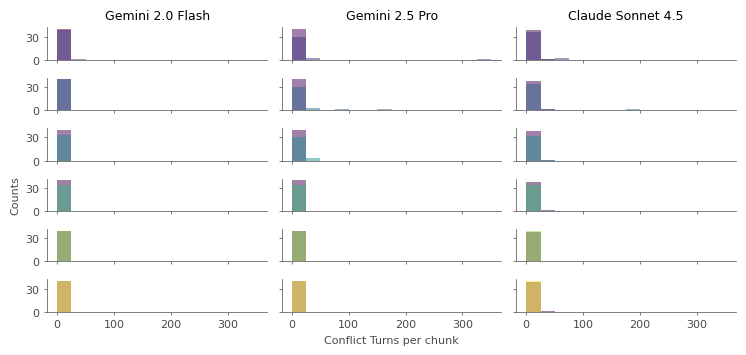

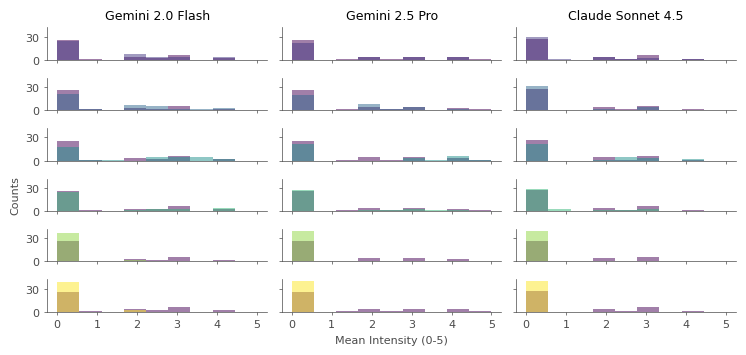

In [88]:
# === CONFLICT VISUALIZATION ===

fig, axes = pu.plot_model_comparison_histograms(
    conflict_turns_by_model,
    MODEL_LABELS,
    bins=15,
    xlabel='Conflict Turns per chunk'
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_conflict_turns.pdf', transparent=True)

fig, axes = pu.plot_model_comparison_histograms(
    mean_intensity_by_model,
    MODEL_LABELS,
    bins=10,
    xlabel='Mean Intensity (0-5)'
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_conflict_intensity.pdf', transparent=True)

In [89]:
# === HUMOR ANALYSIS ===

humor_results = {}
for model in MODELS:
    print(f"Running humor analysis with {model}...")
    humor_results[model] = metrics.analyze_humor(dfs, model=model, force_refresh=FORCE_REFRESH)

humor_turns_by_model = {}
mean_originality_by_model = {}
for i, model in enumerate(MODELS):
    label = MODEL_LABELS[i]
    humor_turns_by_model[label], _ = pu.aggregate_metric(
        humor_results[model], campaign_names, categories, CATEGORY_ORDER, 'humor_turns'
    )
    mean_originality_by_model[label], _ = pu.aggregate_metric(
        humor_results[model], campaign_names, categories, CATEGORY_ORDER, 'mean_originality'
    )

Running humor analysis with gemini/gemini-2.0-flash...
📁 Loaded 49 cached Humor results
Running humor analysis with gemini/gemini-3-flash-preview...
📁 Loaded 49 cached Humor results
Running humor analysis with claude-sonnet-4-5...
📁 Loaded 49 cached Humor results


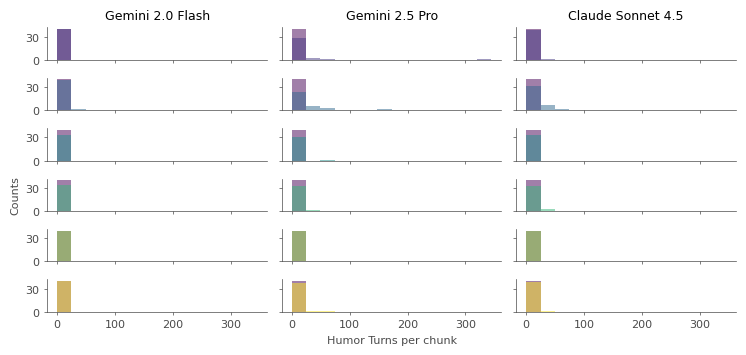

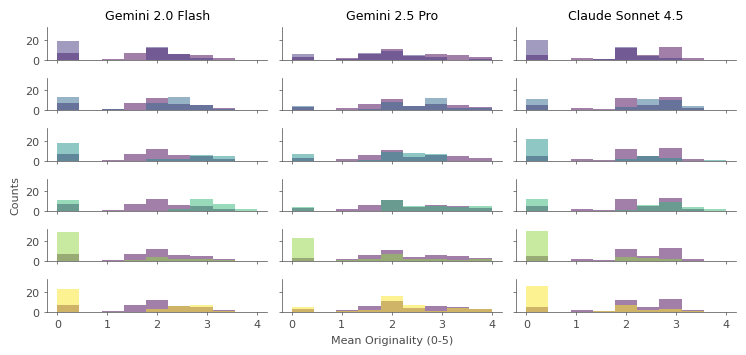

In [90]:
# === HUMOR VISUALIZATION ===

fig, axes = pu.plot_model_comparison_histograms(
    humor_turns_by_model,
    MODEL_LABELS,
    bins=15,
    xlabel='Humor Turns per chunk'
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_humor_turns.pdf', transparent=True)

fig, axes = pu.plot_model_comparison_histograms(
    mean_originality_by_model,
    MODEL_LABELS,
    bins=10,
    xlabel='Mean Originality (0-5)'
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_humor_originality.pdf', transparent=True)

In [91]:
# === COOPERATION ANALYSIS ===

cooperation_results = {}
for model in MODELS:
    print(f"Running cooperation analysis with {model}...")
    cooperation_results[model] = metrics.analyze_cooperation(dfs, model=model, force_refresh=FORCE_REFRESH)

cooperation_turns_by_model = {}
mean_depth_by_model = {}
for i, model in enumerate(MODELS):
    label = MODEL_LABELS[i]
    cooperation_turns_by_model[label], _ = pu.aggregate_metric(
        cooperation_results[model], campaign_names, categories, CATEGORY_ORDER, 'cooperation_turns'
    )
    mean_depth_by_model[label], _ = pu.aggregate_metric(
        cooperation_results[model], campaign_names, categories, CATEGORY_ORDER, 'mean_depth'
    )

Running cooperation analysis with gemini/gemini-2.0-flash...
📁 Loaded 49 cached Cooperation results
Running cooperation analysis with gemini/gemini-3-flash-preview...
📁 Loaded 49 cached Cooperation results
Running cooperation analysis with claude-sonnet-4-5...
📁 Loaded 49 cached Cooperation results


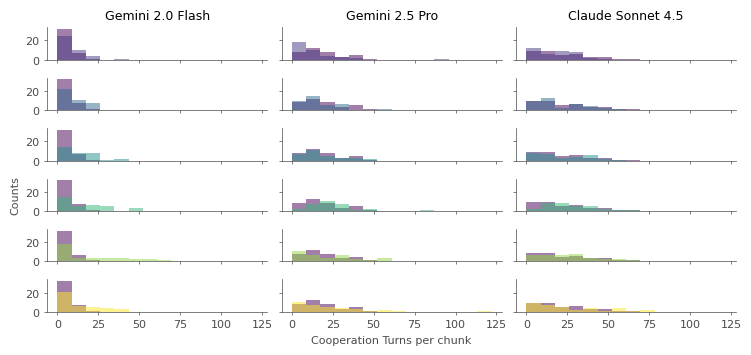

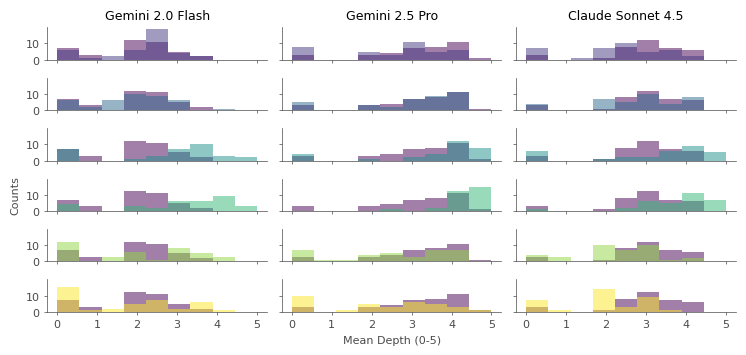

In [92]:
# === COOPERATION VISUALIZATION ===

fig, axes = pu.plot_model_comparison_histograms(
    cooperation_turns_by_model,
    MODEL_LABELS,
    bins=15,
    xlabel='Cooperation Turns per chunk'
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_cooperation_turns.pdf', transparent=True)

fig, axes = pu.plot_model_comparison_histograms(
    mean_depth_by_model,
    MODEL_LABELS,
    bins=10,
    xlabel='Mean Depth (0-5)'
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_cooperation_depth.pdf', transparent=True)

In [93]:
# === NORMS ANALYSIS ===

norms_results = {}
for model in MODELS:
    print(f"Running norms analysis with {model}...")
    norms_results[model] = metrics.analyze_norms(dfs, model=model, force_refresh=FORCE_REFRESH)

norm_proportion_by_model = {}
total_violated_by_model = {}
for i, model in enumerate(MODELS):
    label = MODEL_LABELS[i]
    norm_proportion_by_model[label], _ = pu.aggregate_metric(
        norms_results[model], campaign_names, categories, CATEGORY_ORDER, 'norm_proportion'
    )
    total_violated_by_model[label], _ = pu.aggregate_metric(
        norms_results[model], campaign_names, categories, CATEGORY_ORDER, 'total_violated'
    )

Running norms analysis with gemini/gemini-2.0-flash...
📁 Loaded 49 cached Norms results
Running norms analysis with gemini/gemini-3-flash-preview...
📁 Loaded 49 cached Norms results
Running norms analysis with claude-sonnet-4-5...
📁 Loaded 49 cached Norms results


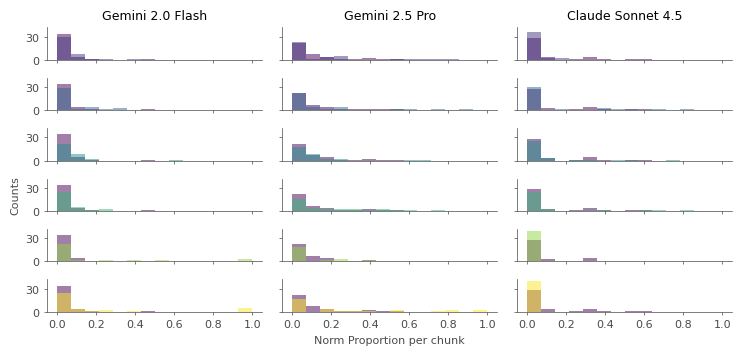

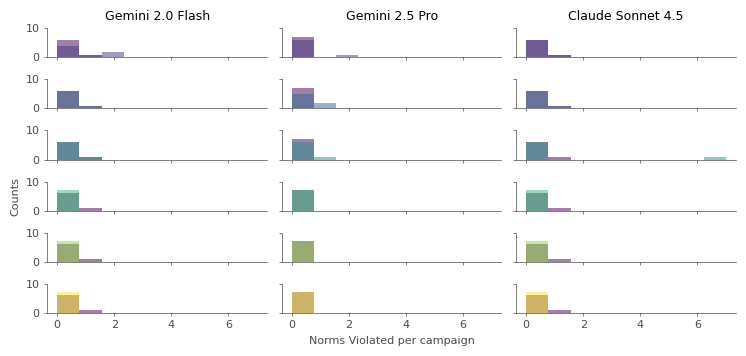

In [94]:
# === NORMS VISUALIZATION ===

fig, axes = pu.plot_model_comparison_histograms(
    norm_proportion_by_model,
    MODEL_LABELS,
    bins=15,
    xlabel='Norm Proportion per chunk'
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_norm_proportion.pdf', transparent=True)

fig, axes = pu.plot_model_comparison_histograms(
    total_violated_by_model,
    MODEL_LABELS,
    bins=10,
    xlabel='Norms Violated per campaign'
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_norms_violated.pdf', transparent=True)

In [95]:
# === COLLABORATIVE CREATIVITY ANALYSIS ===

collab_creativity_results = {}
for model in MODELS:
    print(f"Running collab creativity analysis with {model}...")
    collab_creativity_results[model] = metrics.analyze_collab_creativity(dfs, model=model, force_refresh=FORCE_REFRESH)

collab_creativity_turns_by_model = {}
mean_creativity_by_model = {}
for i, model in enumerate(MODELS):
    label = MODEL_LABELS[i]
    collab_creativity_turns_by_model[label], _ = pu.aggregate_metric(
        collab_creativity_results[model], campaign_names, categories, CATEGORY_ORDER, 'collab_creativity_turns'
    )
    mean_creativity_by_model[label], _ = pu.aggregate_metric(
        collab_creativity_results[model], campaign_names, categories, CATEGORY_ORDER, 'mean_creativity'
    )

Running collab creativity analysis with gemini/gemini-2.0-flash...
📁 Loaded 49 cached Collab creativity results
Running collab creativity analysis with gemini/gemini-3-flash-preview...
📁 Loaded 49 cached Collab creativity results
Running collab creativity analysis with claude-sonnet-4-5...
📁 Loaded 49 cached Collab creativity results


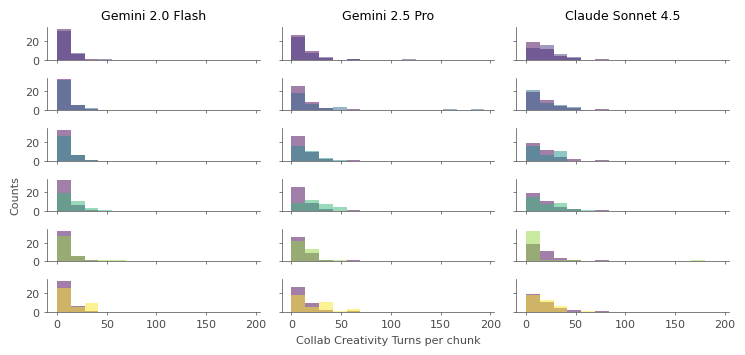

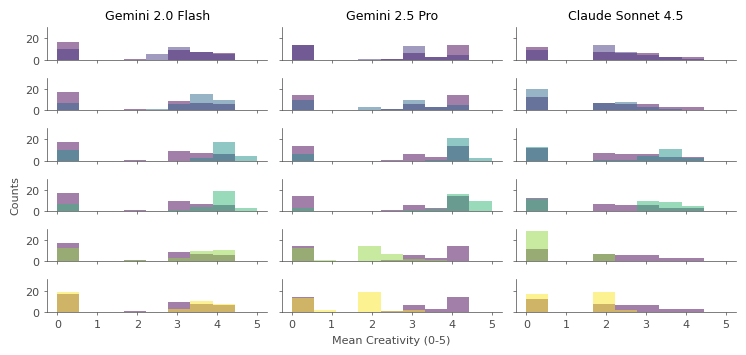

In [96]:
# === COLLABORATIVE CREATIVITY VISUALIZATION ===

fig, axes = pu.plot_model_comparison_histograms(
    collab_creativity_turns_by_model,
    MODEL_LABELS,
    bins=15,
    xlabel='Collab Creativity Turns per chunk'
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_collab_creativity_turns.pdf', transparent=True)

fig, axes = pu.plot_model_comparison_histograms(
    mean_creativity_by_model,
    MODEL_LABELS,
    bins=10,
    xlabel='Mean Creativity (0-5)'
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_collab_creativity.pdf', transparent=True)

In [104]:
# === LONG EPISODE INSPECTOR ===
# Find episodes that seem unrealistically long (potential LLM hallucinations)

MAX_REASONABLE_LENGTH = 50  # Episodes longer than this are suspicious

def inspect_long_episodes(results_by_model, model_labels, max_length=MAX_REASONABLE_LENGTH):
    """Find and display episodes longer than max_length turns."""
    for model_key, label in zip(MODELS, model_labels):
        print(f"\n{'='*60}")
        print(f"MODEL: {label}")
        print('='*60)

        results = results_by_model[model_key]
        long_count = 0

        for campaign_id, result in results.items():
            episodes = result.metadata.get('episodes', [])
            long_eps = [ep for ep in episodes if ep['turn_count'] > max_length]

            if long_eps:
                for ep in long_eps:
                    long_count += 1
                    print(f"\n--- {campaign_id} ---")
                    print(f"Turns {ep['start_turn']}-{ep['end_turn']} ({ep['turn_count']} turns)")
                    print(f"Description: {ep['description']}")
                    if 'originality' in ep:
                        print(f"Originality: {ep['originality']}")
                    elif 'intensity' in ep:
                        print(f"Intensity: {ep['intensity']}")
                    elif 'creativity' in ep:
                        print(f"Creativity: {ep['creativity']}")
                    print(f"\nEpisode text:")
                    print(ep.get('episode_text', '[not stored]')[:50000])

        print(f"\nTotal long episodes (>{max_length} turns): {long_count}")

# Run for humor
inspect_long_episodes(humor_results, MODEL_LABELS)


MODEL: Gemini 2.0 Flash

Total long episodes (>50 turns): 0

MODEL: Gemini 3 Flash

--- 10391-guardians-of-gridori_gemini-1.5-pro_players_scratch_20250817_181454 ---
Turns 48-101 (54 turns)
Description: A recurring mechanical/tactical gag where Dmitrei constantly solves every problem by tossing a "Goodberry" at it. It reaches a comedic peak in Turn 101 when he aggressively throws a berry at a massive, terrifying Hydra and tells it to "Choke on this!" as a distraction.
Originality: 4

Episode text:
Turn 48 - Dmitrei: Dmitrei casts *Entangle* again, focusing the growth of thorny vines between the wolves and Faen. "Behind the brambles, Faen!" he shouts,  "Keep blasting! I'll hold them off!"  He then pulls out a *Goodberry* and tosses it to Thokk.  "Here, Thokk! Eat this and keep fighting!" He keeps a watchful eye on the rumbling ground, his brow furrowed in concern. *What in Aerith's name is happening?*
Turn 49 - Faen: "B-Bastion, it's getting worse!" Faen cries, another Eldritch Blast f

In [105]:
# === CROSS-MODEL EPISODE COMPARISON ===
# Compare episodes identified by different models for the same campaign

def compare_episodes_across_models(results_by_model, model_labels, campaign_id, turn_range=None):
    """
    Compare episodes across models for a specific campaign.

    Args:
        results_by_model: Dict mapping model key to results dict
        model_labels: List of display labels
        campaign_id: Campaign to compare
        turn_range: Optional (start, end) tuple to filter episodes
    """
    print(f"Campaign: {campaign_id}")
    if turn_range:
        print(f"Turn range: {turn_range[0]}-{turn_range[1]}")
    print()

    for model_key, label in zip(MODELS, model_labels):
        print(f"\n{'='*50}")
        print(f"MODEL: {label}")
        print('='*50)

        if campaign_id not in results_by_model[model_key]:
            print("  (campaign not found)")
            continue

        result = results_by_model[model_key][campaign_id]
        episodes = result.metadata.get('episodes', [])

        # Filter by turn range if specified
        if turn_range:
            episodes = [ep for ep in episodes
                       if ep['end_turn'] >= turn_range[0] and ep['start_turn'] <= turn_range[1]]

        if not episodes:
            print("  (no episodes found)")
            continue

        for ep in sorted(episodes, key=lambda x: x['start_turn']):
            rating_key = next((k for k in ['originality', 'intensity', 'depth', 'creativity'] if k in ep), None)
            rating = ep.get(rating_key, '?') if rating_key else '?'
            print(f"  Turns {ep['start_turn']:3d}-{ep['end_turn']:3d} ({ep['turn_count']:2d}t) "
                  f"| {rating_key}={rating} | {ep['description'][:60]}")

# Example: Compare humor episodes for a specific campaign
sample_campaign = list(humor_results[MODELS[0]].keys())[0]
compare_episodes_across_models(humor_results, MODEL_LABELS, sample_campaign)

Campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg


MODEL: Gemini 2.0 Flash
  Turns   3-  3 ( 1t) | originality=1 | Player Dro Coborel jokingly admits to stealing ideas from an
  Turns  11- 11 ( 1t) | originality=2 | Dro Coborel makes a self-deprecating joke about their charac
  Turns  57- 57 ( 1t) | originality=1 | Alendi makes a witty remark after narrowly escaping danger.
  Turns  78- 78 ( 1t) | originality=2 | Dro Coborel makes a self-deprecating joke about their charac
  Turns  94- 94 ( 1t) | originality=2 | Dro Coborel makes a humorous remark about LARPing.
  Turns 103-103 ( 1t) | originality=1 | Brachos makes a humorous remark about the party's compositio
  Turns 106-106 ( 1t) | originality=2 | Brachos jokingly refers to Rylei as "squishy".
  Turns 123-123 ( 1t) | originality=1 | Dro Coborel makes a humorous remark about playing a drow.
  Turns 124-124 ( 1t) | originality=1 | Brachos makes a humorous remark about the party's compositio
  Turns 125-125 ( 1t) | origin

In [106]:
# === CHUNK METRICS COMPARISON ===
# Compare chunk-level metrics across models

def compare_chunk_metrics(results_by_model, model_labels, campaign_id, metric_series='humor_turns'):
    """
    Compare chunk-level metrics across models.

    Args:
        results_by_model: Dict mapping model key to results dict
        model_labels: List of display labels
        campaign_id: Campaign to compare
        metric_series: Name of series to compare
    """
    print(f"Campaign: {campaign_id}")
    print(f"Metric: {metric_series}")
    print()

    # Get max chunks across models
    max_chunks = 0
    for model_key in MODELS:
        if campaign_id in results_by_model[model_key]:
            n = len(results_by_model[model_key][campaign_id].series.get(metric_series, []))
            max_chunks = max(max_chunks, n)

    # Header
    header = f"{'Chunk':>6}"
    for label in model_labels:
        header += f" | {label:>15}"
    print(header)
    print("-" * len(header))

    # Data rows
    for i in range(max_chunks):
        row = f"{i:>6}"
        for model_key in MODELS:
            if campaign_id in results_by_model[model_key]:
                series = results_by_model[model_key][campaign_id].series.get(metric_series, [])
                if i < len(series):
                    row += f" | {series[i]:>15.1f}"
                else:
                    row += f" | {'':>15}"
            else:
                row += f" | {'N/A':>15}"
        print(row)

# Example usage
sample_campaign = list(humor_results[MODELS[0]].keys())[0]
compare_chunk_metrics(humor_results, MODEL_LABELS, sample_campaign, 'humor_turns')

Campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg
Metric: humor_turns

 Chunk | Gemini 2.0 Flash |  Gemini 3 Flash | Claude Sonnet 4.5
---------------------------------------------------------------
     0 |             2.0 |             2.0 |             4.0
     1 |             3.0 |            11.0 |             5.0
     2 |             9.0 |             9.0 |             7.0
     3 |             2.0 |             1.0 |             2.0
     4 |             3.0 |             2.0 |             3.0
     5 |             4.0 |             4.0 |             9.0
     6 |             8.0 |             9.0 |            12.0
     7 |             0.0 |             2.0 |             5.0
     8 |             4.0 |             5.0 |             4.0
     9 |             9.0 |            15.0 |            14.0
    10 |             0.0 |             1.0 |             0.0
